In [161]:
!pwd

/Users/abhinav23run/Desktop/regression_project/isye6414_group_project/ashish


In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [163]:
plt.style.use('seaborn')

### 1. get data and create artist level features

In [164]:
df_org = pd.read_csv("../top_500_artists_deduplicate.csv")
df_org.shape

(4576, 15)

In [165]:
df_org.columns

Index(['name', 'album', 'artist', 'release_date', 'length', 'popularity',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'],
      dtype='object')

*Removing the 8 duplicates instances for now

In [166]:
arist_grp = df_org.groupby(["artist"]).agg({"popularity":["sum","count"]})
arist_grp.describe()

popularity            
               sum       count
count   729.000000  729.000000
mean    448.242798    6.277092
std     297.313613    4.089659
min      29.000000    1.000000
25%      80.000000    1.000000
50%     532.000000    8.000000
75%     678.000000   10.000000
max    2481.000000   37.000000

In [167]:
album_grp = df_org.groupby(["album"]).agg({"popularity":["sum","count"]})
album_grp.describe()

popularity             
               sum        count
count  2927.000000  2927.000000
mean    111.639563     1.563375
std      78.506337     1.058442
min      27.000000     1.000000
25%      68.000000     1.000000
50%      76.000000     1.000000
75%     139.000000     2.000000
max    1020.000000    11.000000

In [168]:
arist_grp = arist_grp.reset_index()
arist_grp.columns = ["artist","popularity_sum", "popularity_count"]

In [171]:
joined1 = df_org.merge(arist_grp,on=["artist"],how="left",suffixes=["_","_artist"])
joined1.shape

(4576, 17)

In [172]:
joined1.columns

Index(['name', 'album', 'artist', 'release_date', 'length', 'popularity',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature',
       'popularity_sum', 'popularity_count'],
      dtype='object')

In [173]:
album_grp = album_grp.reset_index()
album_grp.columns = ["album","popularity_sum", "popularity_count"]

In [176]:
joined2 = joined1.merge(album_grp,on=["album"],how="left",suffixes=["","_album"])
joined2.shape

(4576, 19)

In [177]:
joined2.columns

Index(['name', 'album', 'artist', 'release_date', 'length', 'popularity',
       'danceability', 'acousticness', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature',
       'popularity_sum', 'popularity_count', 'popularity_sum_album',
       'popularity_count_album'],
      dtype='object')

#### Create Artist and Album popularity agg variables

In [178]:
joined2["artist_avg_pop_other"]=(joined2["popularity_sum"]-joined2["popularity"])/\
(joined2["popularity_count"]-1)

joined2["album_avg_pop_other"]=(joined2["popularity_sum_album"]-joined2["popularity"])/\
(joined2["popularity_count_album"]-1)

In [179]:
joined2.head()

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,...,loudness,speechiness,tempo,time_signature,popularity_sum,popularity_count,popularity_sum_album,popularity_count_album,artist_avg_pop_other,album_avg_pop_other
0,Jimmy Cooks (feat. 21 Savage),"Honestly, Nevermind",Drake,2022-06-17,218364,91,0.529,0.000307,0.673,0.000002,...,-4.711,0.1750,165.921,4,1214,15,91,1,80.214286,NaN
1,WAIT FOR U (feat. Drake & Tems),I NEVER LIKED YOU,Future,2022-04-29,189893,90,0.463,0.314000,0.642,0.000000,...,-4.474,0.3400,83.389,4,554,7,246,3,77.333333,78.0
2,One Dance,Views,Drake,2016-05-06,173986,86,0.792,0.007760,0.625,0.001800,...,-5.609,0.0536,103.967,4,1214,15,86,1,80.571429,NaN
3,Knife Talk (with 21 Savage ft. Project Pat),Certified Lover Boy,Drake,2021-09-03,242965,85,0.849,0.063500,0.424,0.000000,...,-9.579,0.3240,145.887,4,1214,15,541,7,80.642857,76.0
4,God's Plan,Scorpion,Drake,2018-06-29,198973,85,0.754,0.033200,0.449,0.000083,...,-9.211,0.1090,77.169,4,1214,15,85,1,80.642857,NaN


In [180]:
joined2[joined2.artist_avg_pop_other.isna()]

,name,album,artist,release_date,length,popularity,danceability,acousticness,energy,instrumentalness,...,loudness,speechiness,tempo,time_signature,popularity_sum,popularity_count,popularity_sum_album,popularity_count_album,artist_avg_pop_other,album_avg_pop_other
28,For My Hand (feat. Ed Sheeran),"Love, Damini",Burna Boy,2022-07-07,159123,84,0.870,0.161000,0.479,0.000157,...,-7.779,0.1650,104.059,4,84,1,84,1,NaN,NaN
37,Lost in the Fire (feat. The Weeknd),Hyperion,Gesaffelstein,2019-03-08,202093,85,0.658,0.093300,0.671,0.000927,...,-12.210,0.0363,100.966,4,85,1,85,1,NaN,NaN
221,THE SCOTTS,THE SCOTTS,THE SCOTTS,2020-04-24,165977,78,0.716,0.233000,0.537,0.000000,...,-7.648,0.0514,129.979,4,78,1,78,1,NaN,NaN
279,family ties (with Kendrick Lamar),The Melodic Blue,Baby Keem,2021-09-10,252262,79,0.711,0.005880,0.611,0.000000,...,-5.453,0.3300,134.093,4,79,1,79,1,NaN,NaN
312,Turn On The Lights again.. (feat. Future),USB,Fred again..,2022-01-18,267946,69,0.683,0.012500,0.887,0.446000,...,-4.944,0.0497,132.007,4,69,1,69,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4509,Waiting On The Sky To Change,Waiting On The Sky To Change,STARSET,2022-08-19,244135,68,0.369,0.000055,0.933,0.000000,...,-4.441,0.1170,168.059,4,68,1,68,1,NaN,NaN
4522,SKRR,MVP,KALIM,2020-09-24,119039,60,0.803,0.163000,0.649,0.000027,...,-6.599,0.1320,125.038,4,60,1,60,1,NaN,NaN
4524,Fendi Drip,MILLIES,Luciano,2019-08-29,220880,60,0.827,0.082700,0.646,0.000000,...,-6.122,0.5050,168.025,4,60,1,60,1,NaN,NaN
4525,Hier,Hier,Lucio101,2022-05-27,151500,59,0.729,0.151000,0.621,0.862000,...,-9.651,0.1090,76.459,4,59,1,59,1,NaN,NaN


### Transform Dates

In [181]:
joined2["release_date"] = pd.to_datetime(joined2["release_date"])

In [182]:
joined2[["release_date"]].describe()

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/2072558924.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  joined2[["release_date"]].describe()


,release_date
count,4576
unique,1504
top,2013-01-01 00:00:00
freq,38
first,1956-03-01 00:00:00
last,2022-10-14 00:00:00


In [183]:
joined2["release_date"].max(),joined2["release_date"].min()

(Timestamp('2022-10-14 00:00:00'), Timestamp('1956-03-01 00:00:00'))

In [184]:
joined2["days_since"] = joined2["release_date"].max() - joined2["release_date"]

In [185]:
joined2[["days_since"]].describe()

,days_since
count,4576
mean,3658 days 03:42:28.951049024
std,4688 days 18:24:49.289123264
min,0 days 00:00:00
25%,553 days 00:00:00
50%,1767 days 00:00:00
75%,4669 days 00:00:00
max,24333 days 00:00:00


### Pre Process for model
1. Remove only 1 song artists
2. Impute Artist Popularity

In [191]:
mask_single_song_artist = joined2.artist_avg_pop_other.isna()
df_model = joined2[~mask_single_song_artist]
df_model.isna().sum()

name                         0
album                        0
artist                       0
release_date                 0
length                       0
popularity                   0
danceability                 0
acousticness                 0
energy                       0
instrumentalness             0
liveness                     0
loudness                     0
speechiness                  0
tempo                        0
time_signature               0
popularity_sum               0
popularity_count             0
popularity_sum_album         0
popularity_count_album       0
artist_avg_pop_other         0
album_avg_pop_other       1804
days_since                   0
dtype: int64

In [192]:
df_model.shape

(4379, 22)

In [193]:
df_model["days_since"] = df_model["days_since"].dt.days

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3129843935.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["days_since"] = df_model["days_since"].dt.days


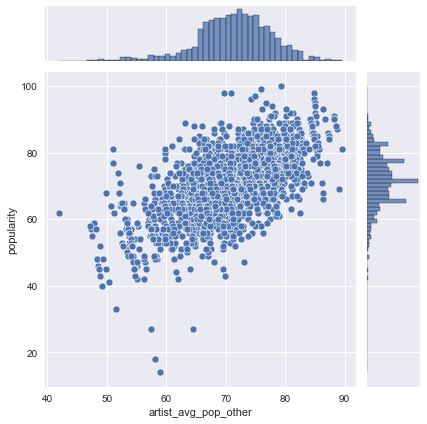

In [194]:
sns.jointplot(data=df_model, x="artist_avg_pop_other", y="popularity")

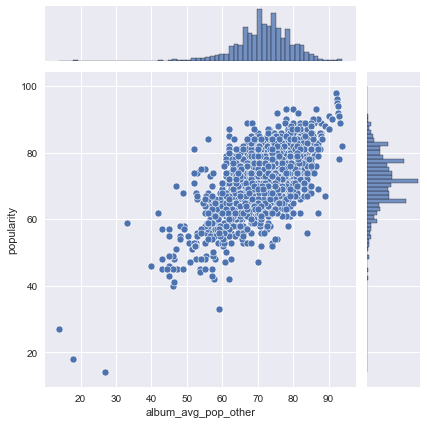

In [195]:
sns.jointplot(data=df_model, x="album_avg_pop_other", y="popularity")

In [196]:
mask_missing_album_popularity = df_model["album_avg_pop_other"].isna()
df_model["imputed_album_avg_pop_other"] = mask_missing_album_popularity.astype("int")

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3583718914.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["imputed_album_avg_pop_other"] = mask_missing_album_popularity.astype("int")


In [197]:
df_model["album_avg_pop_other"][mask_missing_album_popularity] = df_model["artist_avg_pop_other"][mask_missing_album_popularity]

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/2765338109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["album_avg_pop_other"][mask_missing_album_popularity] = df_model["artist_avg_pop_other"][mask_missing_album_popularity]
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/2765338109.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model["album_avg_pop_other"][mask_missing_album_popularity] = df_model["artist_avg_pop_other"][mask_missing_album_popularity]


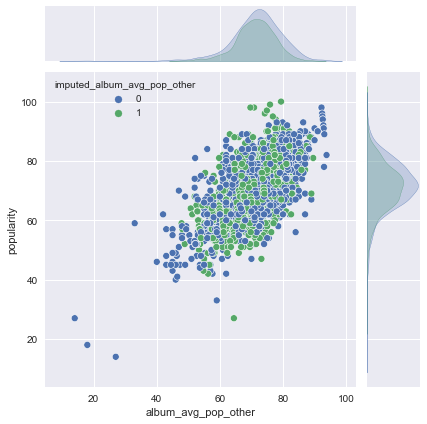

In [198]:
sns.jointplot(data=df_model, x="album_avg_pop_other", y="popularity", hue="imputed_album_avg_pop_other")

In [199]:
numeric_cols = list(df_model.select_dtypes(include=np.number).columns)
numeric_cols

['length',
 'popularity',
 'danceability',
 'acousticness',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'speechiness',
 'tempo',
 'time_signature',
 'popularity_sum',
 'popularity_count',
 'popularity_sum_album',
 'popularity_count_album',
 'artist_avg_pop_other',
 'album_avg_pop_other',
 'days_since',
 'imputed_album_avg_pop_other']

### Regression Model

In [200]:
X_cols = numeric_cols[0:1]+numeric_cols[2:]
Y_cols = numeric_cols[1]

In [201]:
### Subset X and Y
X = df_model[X_cols]
y = df_model[Y_cols]

### Scale the data
# scaler = MinMaxScaler()
# X_scaled[X_cols] = scaler.fit_transform(X)

In [202]:
X.shape

(4379, 18)

In [234]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
results.rsquared

0.581076060168243

In [219]:
results_lasso=model.fit_regularized(method='elastic_net',L1_wt=1.0,alpha=1)

In [233]:
results.params

const                          69.695688
length                         -0.000005
danceability                    1.185318
acousticness                    0.335036
energy                         -0.712510
instrumentalness                0.975678
liveness                        0.186758
loudness                        0.062721
speechiness                     2.916429
tempo                           0.002025
time_signature                 -0.430249
popularity_sum                  0.052841
popularity_count               -3.712997
popularity_sum_album            0.125668
popularity_count_album         -9.302512
artist_avg_pop_other           -0.050375
album_avg_pop_other             0.106918
days_since                      0.000040
imputed_album_avg_pop_other    -0.617860
dtype: float64

In [264]:
frames = []
for n in np.arange(0.1, 1, 0.1).tolist():
    results_lasso = model.fit_regularized(L1_wt=1, alpha=n, start_params=results.params)

    results_lasso_fit = sm.regression.linear_model.OLSResults(model, 
                                                           results_lasso.params, 
                                                           model.normalized_cov_params)
    frames.append(np.append(results_fr.params, np.append(results_lasso_fit.ssr,np.append(results_lasso_fit.rsquared , results_lasso_fit.rsquared_adj))))

    df = pd.DataFrame(frames, columns=list(X.columns) +['ssr'] +['r-squared']+['adjusted-r-squared'])
df.index=np.arange(0.1, 1, 0.1).tolist()
df.index.name = 'alpha*'
df.T

alpha*,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
const,64.294982,64.294982,64.294982,64.294982,64.294982,64.294982,64.294982,64.294982,64.294982
length,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002,0.000002
danceability,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
acousticness,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
energy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
instrumentalness,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
liveness,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
loudness,-0.056223,-0.056223,-0.056223,-0.056223,-0.056223,-0.056223,-0.056223,-0.056223,-0.056223
speechiness,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
tempo,0.013225,0.013225,0.013225,0.013225,0.013225,0.013225,0.013225,0.013225,0.013225


Text(0.5, 1.0, 'SSR')

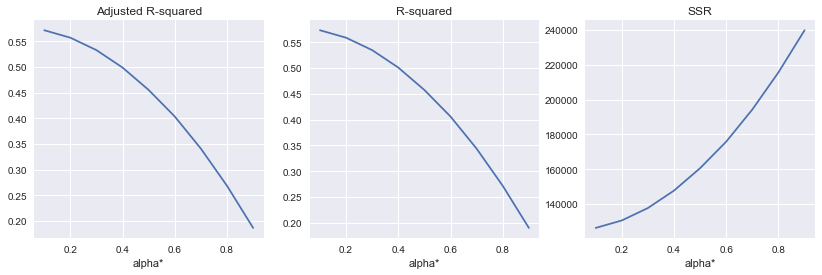

In [270]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

ax[0] = df.iloc[:, -1].plot(ax=ax[0])
ax[0].set_title('Adjusted R-squared')

ax[1] = df.iloc[:, -2].plot(ax=ax[1])
ax[1].set_title('R-squared')

ax[2] = df.iloc[:, -3].plot(ax=ax[2])
ax[2].set_title('SSR')

### Observing the above plots , it make sense to go ahead with a lasso regularized model (as a feature selection technique) for alpha = 0.1 ###

In [279]:
results_lasso = model.fit_regularized(L1_wt=1, alpha=0.1, start_params=results.params)
final = sm.regression.linear_model.OLSResults(model, 
                                              results_lasso.params, 
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     325.5
Date:                Sun, 27 Nov 2022   Prob (F-statistic):               0.00
Time:                        13:20:29   Log-Likelihood:                -13574.
No. Observations:                4379   AIC:                         2.719e+04
Df Residuals:                    4360   BIC:                         2.731e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          64.2950      3.106     20.700      0.000      58.206      70.384
length                       2.193e-06   1.57e-06      1.395      0.163   -8.88e-07    5.27e-06
danceability                         0      0.606          0      1.000      -1.187       1.187
acousticness                         0      0.413          0      1.000      -0.810       0.810
energy                               0      0.745          0      1.000      -1.460       1.460
instrumentalness                     0      0.809          0      1.000      -1.585       1.585
liveness                             0      0.549          0      1.000      -1.076       1.076
loudness                       -0.0562      0.046     -1.232      0.218      -0.146       0.033
speechiness                          0      0.868          0      1.000      -1.701       1.701
tempo                           0.0132      0.003      4.547      0.000       0.008       0.019
time_signature                       0      0.271          0      1.000      -0.532       0.532
popularity_sum                  0.0532      0.004     12.782      0.000       0.045       0.061
popularity_count               -3.7019      0.290    -12.753      0.000      -4.271      -3.133
popularity_sum_album            0.1210      0.005     22.044      0.000       0.110       0.132
popularity_count_album         -8.7535      0.409    -21.383      0.000      -9.556      -7.951
artist_avg_pop_other           -0.0494      0.045     -1.098      0.272      -0.137       0.039
album_avg_pop_other             0.1052      0.025      4.144      0.000       0.055       0.155
days_since                  -2.043e-05   2.03e-05     -1.008      0.314   -6.02e-05    1.93e-05
imputed_album_avg_pop_other          0      0.232          0      1.000      -0.454       0.454
==============================================================================
Omnibus:                      351.493   Durbin-Watson:                   1.296
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1589.635
Skew:                          -0.259   Prob(JB):                         0.00
Kurtosis:                       5.906   Cond. No.                     8.67e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [305]:
lasso_params=pd.Series(results_lasso.params)
columns_lasso=list(lasso_params[lasso_params!=0].index)
X_lasso=X[columns_lasso]

## Analyzing Variance Inflation factor to check for multicollinearity (overall model)

In [307]:
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

In [308]:
vif

,VIF,variable
0,1458.617918,const
1,1.195639,length
2,1.296224,danceability
3,1.672081,acousticness
4,2.964881,energy
5,1.221461,instrumentalness
6,1.062107,liveness
7,2.991028,loudness
8,1.223119,speechiness
9,1.061780,tempo


## We can see that there are various variables which are highly correlated. 

## Analyzing VIF after applying LASSO regression as a method for feature selection 

In [309]:
vif_lasso = pd.DataFrame()
vif_lasso['VIF'] = [variance_inflation_factor(X_lasso.values, i) for i in range(X_lasso.shape[1])]
vif_lasso['variable'] = X_lasso.columns

In [310]:
vif_lasso

,VIF,variable
0,1113.595066,const
1,1.127613,length
2,1.157547,loudness
3,1.011715,tempo
4,169.745306,popularity_sum
5,157.633436,popularity_count
6,65.305711,popularity_sum_album
7,61.240992,popularity_count_album
8,11.676567,artist_avg_pop_other
9,4.906916,album_avg_pop_other


In [256]:
def _get_r_sq(X,y):
    model = sm.OLS(y, X)
    results = model.fit()
    return (results.rsquared)

def get_left_right(X,y,threshold):
    mask_left = X["days_since"] <= threshold
    X_left = X.loc[mask_left]
    y_left = y.loc[mask_left]
    X_right = X.loc[~mask_left]
    y_right = y.loc[~mask_left]
    return (_get_r_sq(X_left,y_left),_get_r_sq(X_right,y_right),sum(mask_left))

In [206]:
X1 = X[list(X.columns[:11]) + ["days_since"]]

In [207]:
result_dict = {
    threshold:get_left_right(X1,y,threshold)\
    for threshold in np.linspace(30,1000,200).astype(int)
}

In [208]:
result_df = pd.DataFrame.from_dict(result_dict,orient="index")
result_df.columns = ["r_sq(days since<=threshold)","r_sq(days since > threshold)","count_days_since_lt_threshold"]

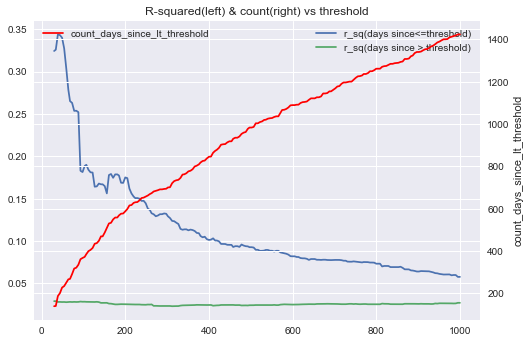

In [209]:
result_df[["r_sq(days since<=threshold)","r_sq(days since > threshold)"]].plot()
ax2 = plt.twinx()
sns.lineplot(data=result_df["count_days_since_lt_threshold"], color="r",\
             label="count_days_since_lt_threshold", ax=ax2)
plt.title("R-squared(left) & count(right) vs threshold")
plt.legend()

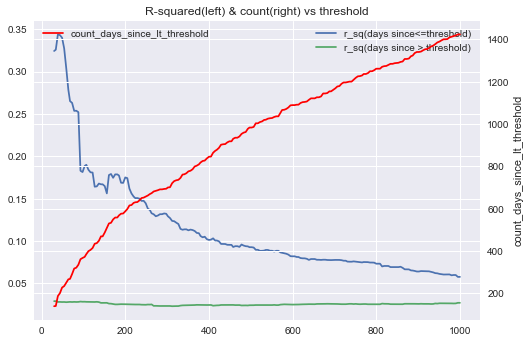

In [210]:
result_dict1 = {
    threshold:get_left_right(X1,y,threshold)\
    for threshold in np.linspace(30,1000,200).astype(int)
}

result_df1 = pd.DataFrame.from_dict(result_dict,orient="index")
result_df1.columns = ["r_sq(days since<=threshold)","r_sq(days since > threshold)","count_days_since_lt_threshold"]

result_df1[["r_sq(days since<=threshold)","r_sq(days since > threshold)"]].plot()
ax2 = plt.twinx()
sns.lineplot(data=result_df1["count_days_since_lt_threshold"], color="r",\
             label="count_days_since_lt_threshold", ax=ax2)
plt.title("R-squared(left) & count(right) vs threshold")
plt.legend()

In [213]:
def r_squared(X,y,threshold):
    X_filtered=X.loc[X["days_since"]<threshold]d
    y_filtered=y[X.loc[X["days_since"]<threshold].index]
    model_filtered = sm.OLS(y_filtered, X_filtered)
    results_filtered=model_filtered.fit()d

    return {'threshold':threshold,'rsquared':results_filtered.rsquared,'adjusted-rsquared':results_filtered.rsquared_adj}

In [329]:
def r_squared_feature_transformations(X,y,threshold):
    X_filtered=X.loc[X["days_since"]<threshold]
    y_filtered=y[X.loc[X["days_since"]<threshold].index]
    X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']
    X_filtered_subset = X_filtered.loc[:,X_filtered.columns.difference(['popularity_sum','popularity_count','popularity_sum_album','popularity_count_album','album_avg_pop_other'])]
    model_filtered_subset = sm.OLS(y_filtered, X_filtered_subset)
    results = model_filtered_subset.fit()

    return {'threshold':threshold,'rsquared':results.rsquared,'adjusted-rsquared':results.rsquared_adj}

In [330]:
r_squared_threshold=[]
r_squared_threshold_features=[]
for thresh in np.arange(30,2030,100):
    r_squared_threshold.append(r_squared(X,y,thresh))
df_threshold=pd.DataFrame.from_dict(r_squared_threshold)

for thresh in np.arange(30,2030,100):
    r_squared_threshold_features.append(r_squared_feature_transformations(X,y,thresh))
df_threshold_features=pd.DataFrame.from_dict(r_squared_threshold_features)

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3656038558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3656038558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3656038

In [331]:
r_squared_lasso=[]
r_squared_lasso_feature_eng=[]

In [332]:
for thresh in np.arange(30,2030,100):
    r_squared_lasso.append(r_squared(X_lasso,y,thresh))
df_threshold_lasso=pd.DataFrame.from_dict(r_squared_lasso)

for thresh in np.arange(30,2030,100):
    r_squared_lasso_feature_eng.append(r_squared_feature_transformations(X_lasso,y,thresh))
df_threshold_features_lasso=pd.DataFrame.from_dict(r_squared_lasso_feature_eng)

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3656038558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3656038558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']
/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3656038

## Plotting R-squared and Adjusted R-squared for overall dataframe (segregated by days since release)

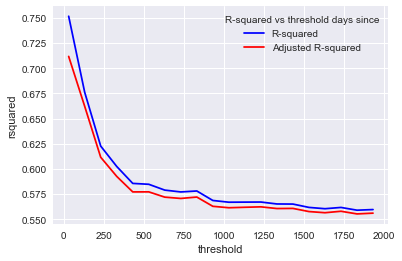

In [333]:
sns.lineplot(x="threshold",y="rsquared",data=df_threshold[["threshold","rsquared"]],color="blue")
sns.lineplot(x="threshold",y="adjusted-rsquared",data=df_threshold[["threshold","adjusted-rsquared"]],color="red")
plt.legend(title='R-squared vs threshold days since', loc='upper right', labels=['R-squared', 'Adjusted R-squared'])

## Plotting R-squared and Adjusted R-squared for dataframe with correlated features removed (segregated by days since)

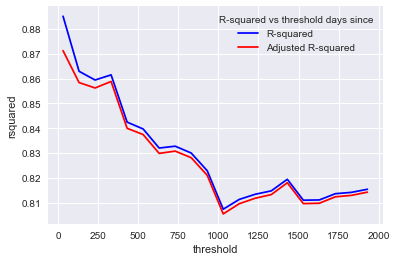

In [334]:
sns.lineplot(x="threshold",y="rsquared",data=df_threshold_features[["threshold","rsquared"]],color="blue")
sns.lineplot(x="threshold",y="adjusted-rsquared",data=df_threshold_features[["threshold","adjusted-rsquared"]],color="red")
plt.legend(title='R-squared vs threshold days since', loc='upper right', labels=['R-squared', 'Adjusted R-squared'])

## Plotting R-squared and Adjusted R-squared for dataframe with reduced features obtained by LASSO (segregated by days since release)

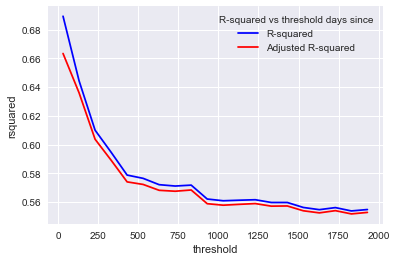

In [335]:
sns.lineplot(x="threshold",y="rsquared",data=df_threshold_lasso[["threshold","rsquared"]],color="blue")
sns.lineplot(x="threshold",y="adjusted-rsquared",data=df_threshold_lasso[["threshold","adjusted-rsquared"]],color="red")
plt.legend(title='R-squared vs threshold days since', loc='upper right', labels=['R-squared', 'Adjusted R-squared'])

## Plotting R-squared and Adjusted R-squared for dataframe with reduced features obtained by LASSO and with engineered features (segregated by days since release)

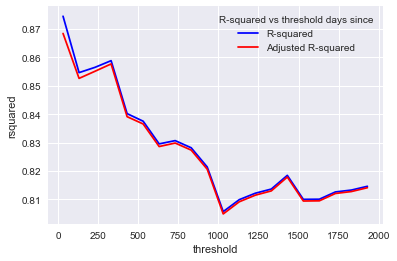

In [336]:
sns.lineplot(x="threshold",y="rsquared",data=df_threshold_features_lasso[["threshold","rsquared"]],color="blue")
sns.lineplot(x="threshold",y="adjusted-rsquared",data=df_threshold_features_lasso[["threshold","adjusted-rsquared"]],color="red")
plt.legend(title='R-squared vs threshold days since', loc='upper right', labels=['R-squared', 'Adjusted R-squared'])

In [337]:
df_threshold_features_lasso

,threshold,rsquared,adjusted-rsquared
0,30,0.874515,0.868443
1,130,0.854652,0.852624
2,230,0.856523,0.855144
3,330,0.858860,0.857711
4,430,0.840200,0.839129
5,530,0.837534,0.836564
6,630,0.829544,0.828612
7,730,0.830694,0.829841
8,830,0.828167,0.827356
9,930,0.821411,0.820618


## Loudness and tempo are the only key song features having some predicitive say in popularity prediction

In [325]:
X_lasso

,const,length,loudness,tempo,popularity_sum,popularity_count,popularity_sum_album,popularity_count_album,artist_avg_pop_other,album_avg_pop_other,days_since
0,1.0,218364,-4.711,165.921,1214,15,91,1,80.214286,80.214286,119
1,1.0,189893,-4.474,83.389,554,7,246,3,77.333333,78.000000,168
2,1.0,173986,-5.609,103.967,1214,15,86,1,80.571429,80.571429,2352
3,1.0,242965,-9.579,145.887,1214,15,541,7,80.642857,76.000000,406
4,1.0,198973,-9.211,77.169,1214,15,85,1,80.642857,80.642857,1568
...,...,...,...,...,...,...,...,...,...,...,...
4570,1.0,220160,-7.626,107.043,530,8,203,3,66.714286,70.000000,1904
4571,1.0,143152,-5.148,113.973,530,8,122,2,66.857143,60.000000,798
4572,1.0,196386,-4.391,86.984,2481,37,132,2,67.222222,71.000000,1400
4573,1.0,197855,-5.405,98.017,530,8,122,2,67.142857,62.000000,798


In [327]:
X_filtered=X.loc[X["days_since"]<30]
y_filtered=y[X.loc[X["days_since"]<30].index]
X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']
X_filtered_subset = X_filtered.loc[:,X_filtered.columns.difference(['popularity_sum','popularity_count','popularity_sum_album','popularity_count_album'])]

/var/folders/79/wlb93l7n51xbb60lcrj4jbr00000gn/T/ipykernel_14519/3101806011.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_filtered['popularity_mean'] = X_filtered['popularity_sum']/X_filtered['popularity_count']


In [328]:
X_filtered_subset

,acousticness,album_avg_pop_other,artist_avg_pop_other,const,danceability,days_since,energy,imputed_album_avg_pop_other,instrumentalness,length,liveness,loudness,popularity_mean,speechiness,tempo,time_signature
26,0.05290,76.083333,76.083333,1.0,0.574,15,0.852,1,0.000000,209026,0.1610,-1.248,76.769231,0.0397,123.038,4
88,0.61900,61.800000,67.666667,1.0,0.881,8,0.592,0,0.000013,154486,0.0901,-4.898,68.200000,0.0324,101.058,4
105,0.15200,87.000000,87.000000,1.0,0.906,23,0.807,1,0.000044,198247,0.1090,-3.963,82.000000,0.0904,97.009,4
190,0.02790,75.000000,75.000000,1.0,0.741,21,0.730,1,0.000264,186514,0.0851,-7.070,75.300000,0.0349,124.001,4
280,0.01300,79.375000,79.375000,1.0,0.714,22,0.472,1,0.000005,156943,0.2660,-7.375,81.666667,0.0864,131.121,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4456,0.24800,67.000000,67.000000,1.0,0.585,14,0.540,0,0.000000,184526,0.2700,-8.308,66.333333,0.3870,75.246,4
4478,0.05660,68.000000,68.000000,1.0,0.888,21,0.778,1,0.000000,160161,0.0653,-3.671,71.333333,0.0945,142.128,4
4483,0.02790,67.400000,67.400000,1.0,0.572,9,0.881,1,0.000031,141133,0.3420,-5.041,67.666667,0.1420,160.182,4
4547,0.00203,71.000000,68.750000,1.0,0.646,7,0.863,0,0.000000,229436,0.0686,-2.046,67.777778,0.0367,120.080,4
